# Data Description
- Wage and other data for a group of 3000 male workers in the Mid-Atlantic region.
- There are 3000 rows.
- The response variable is `wage`.
- There are 11 variables:
    - year: Year that wage information was recorded
    - age: Age of worker
    - maritl: A factor with levels ‘1. Never Married’, ‘2. Married’, ‘3. ‘3. Widowed’, ‘4. Divorced’ and ‘5. Separated’ indicating marital status
    - race: A factor with levels ‘1. White’, ‘2. Black’, ‘3. Asian’ and ‘4. Other’ indicating race
    - education: A factor with levels ‘1. < HS Grad’, ‘2. HS Grad’, ‘3. Some College’, ‘4. College Grad’ and ‘5. Advanced Degree’ indicating education level
    - region: Region of the country (mid-atlantic only)
    - jobclass: A factor with levels ‘1. Industrial’ and ‘2. Information’ indicating type of job
    - health: A factor with levels ‘1. <=Good’ and ‘2. >=Very Good’ indicating health level of worker
    - health_ins: A factor with levels ‘1. Yes’ and ‘2. No’ indicating whether worker has health insurance
    - logwage: Log of workers wage
    - wage: Workers raw wage

# Load Packages and Data

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, bs, ns,
                         ModelSpec as MS)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

In [3]:
WageDF = load_data('Wage')
WageDF.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
WageDF.describe().round(3)

,year,age,logwage,wage
count,3000.000,3000.000,3000.000,3000.000
mean,2005.791,42.415,4.654,111.704
std,2.026,11.542,0.352,41.729
min,2003.000,18.000,3.000,20.086
25%,2004.000,33.750,4.447,85.384
50%,2006.000,42.000,4.653,104.922
75%,2008.000,51.000,4.857,128.680
max,2009.000,80.000,5.763,318.342


# Polynomial Regression
- We use `poly()` from `ISLP.models` to create a model matrix for fitting a 4th-degree polynomial in `age`.

In [5]:
# Create a matrix of polynomial basis functions for age 
poly_age = MS([poly('age', degree=4)]).fit_transform(WageDF)
poly_age.head(3)

,intercept,"poly(age, degree=4)[0]","poly(age, degree=4)[1]","poly(age, degree=4)[2]","poly(age, degree=4)[3]"
0,1.0,-0.038625,0.055909,-0.071741,0.086730
1,1.0,-0.029133,0.026298,-0.014550,-0.002599
2,1.0,0.004090,-0.014507,-0.000133,0.014480


In [6]:
# Fit a linear model using the transformed features
M = sm.OLS(WageDF.wage, poly_age).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


- We create 100 evenly spaced `age` values from the min and max ages to create a smooth curve.

In [7]:
age_grid = np.linspace(WageDF.age.min(), WageDF.age.max(), 100)
ageDF = pd.DataFrame({'age': age_grid})
ageDF.head(3)

,age
0,18.000000
1,18.626263
2,19.252525


In [8]:
# Show the matrix of polynomial basis functions for ageDF
MS([poly('age', degree=4)]).fit(WageDF).transform(ageDF).head(3)

,intercept,"poly(age, degree=4)[0]","poly(age, degree=4)[1]","poly(age, degree=4)[2]","poly(age, degree=4)[3]"
0,1.0,-0.038625,0.055909,-0.071741,0.086730
1,1.0,-0.037634,0.052445,-0.064068,0.072513
2,1.0,-0.036643,0.049068,-0.056818,0.059599


- We plot the fitted values with confidence intervals.

In [9]:
# Calculate the predicted values for the age grid
preds = M.get_prediction(MS([poly('age', degree=4)]).fit(WageDF).transform(ageDF))
preds.summary_frame().head(3)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,51.931450,5.298268,41.542837,62.320064,-27.018198,130.881099
1,56.101820,4.699613,46.887024,65.316616,-22.701963,134.905603
2,60.076095,4.160352,51.918658,68.233531,-18.611055,138.763244


In [10]:
# Calculate the confidence bands for the age grid
bands = preds.conf_int(alpha=0.05)
bands[:3,]

array([[41.54283703, 62.32006359],
       [46.8870235 , 65.31661645],
       [51.91865766, 68.2335314 ]])

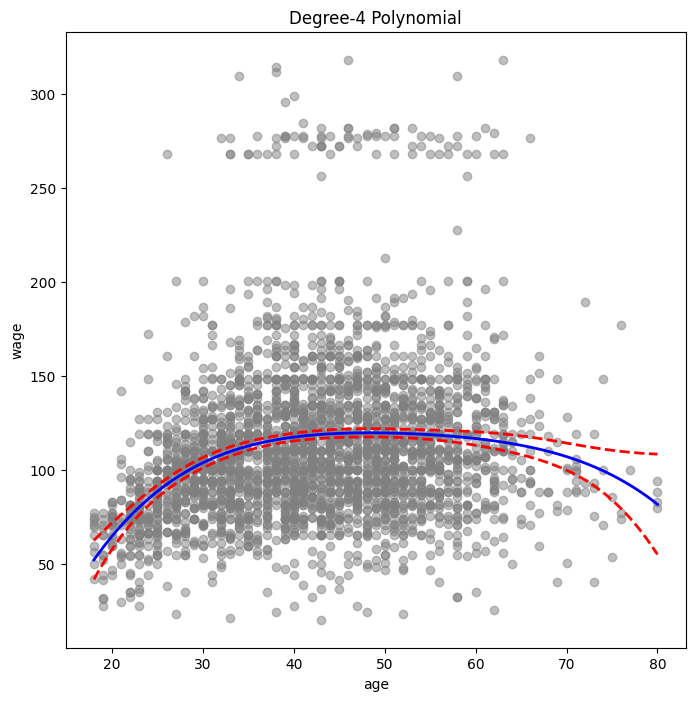

In [11]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
# Plot the predicted values with confidence bands
for value, style in zip( [preds.predicted_mean, bands[:,0], bands[:,1]], 
                   ['b','r--','r--'] ):
    ax.plot(age_grid, value, style, linewidth=2)
ax.set_xlabel('age'); ax.set_ylabel('wage'); ax.set_title('Degree-4 Polynomial');

## Choose the Degree of the Polynomial
- We can use Anova or cross-validation to choose the degree of the polynomial. In this part, we use Anova.
- We fit models from degree 1 to 5. Degree 1 is a linear model.
- Then, we use `anova_lm()` from `statsmodels.stats.anova` to conduct a series of ANOVA tests.
    - The null hypothesis is that the two models are equal.
    - The alternative hypothesis is that the larger model is better.
- The models must be nested for the ANOVA test to be valid.
- The result does not show F-statistics and p-value for the first model because there is no smaller model to compare it to.

In [12]:
# Create 5 matrices of polynomial basis functions for age
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(WageDF) for model in models]
len(Xs)

5

In [13]:
# Show some elements of degree-1 
Xs[0].head(3)

,intercept,"poly(age, degree=1)"
0,1.0,-0.038625
1,1.0,-0.029133
2,1.0,0.004090


In [14]:
# Show some elements of degree-2
Xs[1].head(3)

,intercept,"poly(age, degree=2)[0]","poly(age, degree=2)[1]"
0,1.0,-0.038625,0.055909
1,1.0,-0.029133,0.026298
2,1.0,0.004090,-0.014507


In [15]:
# Run the linear regression for each model
lin_reg1 = sm.OLS(WageDF.wage, Xs[0]).fit()
lin_reg2 = sm.OLS(WageDF.wage, Xs[1]).fit()
lin_reg3 = sm.OLS(WageDF.wage, Xs[2]).fit()
lin_reg4 = sm.OLS(WageDF.wage, Xs[3]).fit()
lin_reg5 = sm.OLS(WageDF.wage, Xs[4]).fit()

In [16]:
# Run an ANOVA on the models
anova_lm(lin_reg1, lin_reg2, lin_reg3, lin_reg4, lin_reg5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [17]:
# Faster way to run an ANOVA on the models
anova_lm(*[sm.OLS(WageDF.wage, X_).fit() for X_ in Xs])
# [sm.OLS(y, X_).fit() for X_ in Xs] is a list comprehension of 5 linear models.
# The * operator is used to unpack the list of fitted models into separate arguments.

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


- Compare model[0] (linear) to model[1] (quadratic): p-value is 0.000, which means that the linear model is not sufficient to explain the data.
- Compare model[1] (quadratic) to model[2] (cubic): p-value is 0.0017, which means that the quadratic model is also not sufficient.
- Compare model[2] (cubic) to model[3] (quartic): p-value is 0.05. Compare model[3] (quartic) to model[4] (quintic): p-value is 0.37. This means that the cubic or quartic model is sufficient to fit the data.
- Instead of ANOVA, we can get these p-values easier because `poly()` generates orthogonal polynomials, which mean that the predictors in `poly_age.transform(Wage)` are uncorrelated.

In [18]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


- The p-values are identical to the ANOVA test results. 
- The square of the t-statistics equals the F-statistics.
- In Anova, the last row compare 5-th degree to 4-th degree. However, the previous model runs only until 4-th degree. Hence, we can see the p-value till 4-th degree, which is 0.051. The p-value of 0.37 is not shown in the summary.

In [19]:
# t-value² of 
(-11.983)**2

143.59228900000002

- We compare three models: linear, quaratic, and cubic in `age`, together with linear in `eduacation`.

In [20]:
models = [MS(['education', poly('age', degree=d)]) for d in range(1, 4)]
XEs = [model.fit_transform(WageDF) for model in models]
anova_lm(*[sm.OLS(WageDF.wage, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


# Polynomial Classification
- We change the task into classification by creating a binary response variable `high_earn` that indicates whether an individual earns more than $250,000 annually.

In [21]:
# Create the response variable for high earners
high_earn = WageDF.wage > 250
# Fit a logistic regression model
poly_age = MS([poly('age', degree=4)]).fit_transform(WageDF)
glm = sm.GLM(high_earn, poly_age, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


- We repeat: predict for 100 values of `age_df`, and plot the fitted values with confidence intervals.

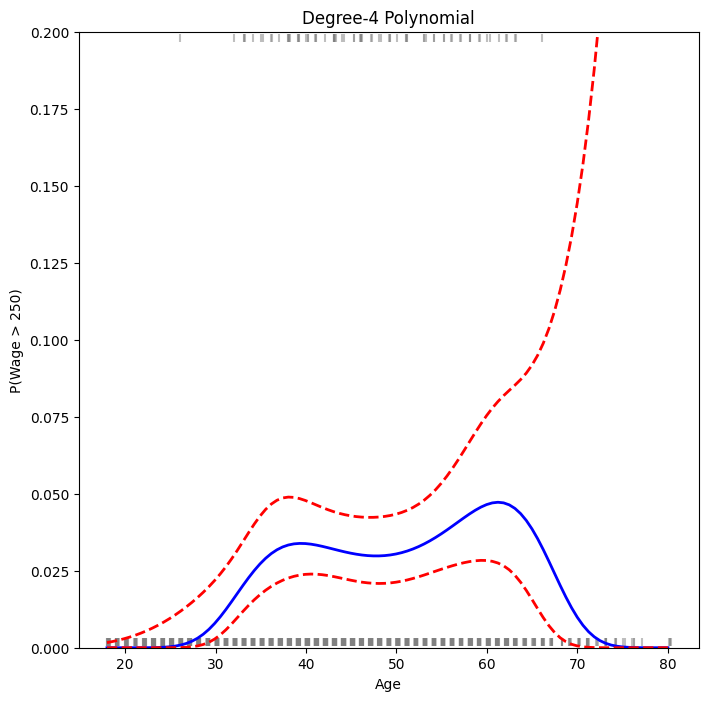

In [22]:
# Make predictions and calculate confidence bands
preds = B.get_prediction(MS([poly('age', degree=4)]).fit(WageDF).transform(ageDF))
bands = preds.conf_int(alpha=0.05)
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age + 0.3*np.random.rand(3000), np.where(high_earn, 0.198, 0.002), facecolor='gray', alpha=0.5, marker='|')
# We use rug plot for age
# Plot the predicted values with confidence bands
for value, style in zip([preds.predicted_mean, bands[:,0], bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(age_grid, value, style, linewidth=2)
ax.set_title('Degree-4 Polynomial'); ax.set_ylim([0,0.2])
ax.set_xlabel('Age'); ax.set_ylabel('P(Wage > 250)');

# Step Functions
- We change to a step function with 4 degrees of freedom.
- We use `pd.qcut()` to create 4 bins at the 25%, 50%, and 75% for `age` and `pd.get_dummies` to create dummy variables.
- `pd.cut()` can be used to create bins not based on quantiles.

In [23]:
# Cut the age variable into quartiles
cut_age = pd.qcut(WageDF.age, 4)
cut_age.head(3)
# First and second age belongs to the first quartile

0    (17.999, 33.75]
1    (17.999, 33.75]
2       (42.0, 51.0]
Name: age, dtype: category
Categories (4, interval[float64, right]): [(17.999, 33.75] < (33.75, 42.0] < (42.0, 51.0] < (51.0, 80.0]]

In [24]:
# Create a design matrix for the quartiles
pd.get_dummies(cut_age).head(3)

,"(17.999, 33.75]","(33.75, 42.0]","(42.0, 51.0]","(51.0, 80.0]"
0,True,False,False,False
1,True,False,False,False
2,False,False,True,False


In [25]:
# Fit a linear regression model
step_model = sm.OLS(WageDF.wage, pd.get_dummies(cut_age)).fit()
summarize(step_model)

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


- The model does not have an intercept.
- 94158 represents the average salary for those under 33.75
- 116660 represents the average salary for those between 33.75 and 42
- 119188 represents the average salary for those between 42 and 51
- 116571 represents the average salary for those over 51

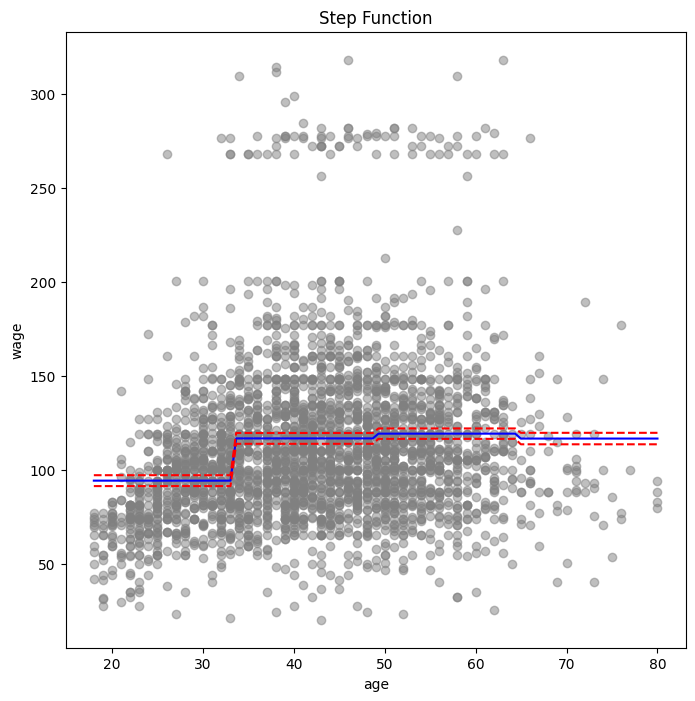

In [26]:
# Create dummy variables for the age grid
cut_age_grid = pd.qcut(age_grid, 4, labels=cut_age.cat.categories)
age_grid_dummies = pd.get_dummies(cut_age_grid)
# Make predictions on the age grid
preds = step_model.get_prediction(age_grid_dummies)
# Calculate the confidence bands
bands = preds.conf_int(alpha=0.05)
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
# Plot the predicted values with confidence bands
for value, style in zip([preds.predicted_mean, bands[:,0], bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(age_grid, value, style)
ax.set_xlabel('age'); ax.set_ylabel('wage'); ax.set_title('Step Function');

# Splines
- We use `ISLP.transforms` to fit regression splines.
    - `ISLP.transforms` wraps the actual spline evaluation functions found in `scipy.interpolate`.
- First, we create a matrix of basis functions to fit a regression spline.
## B-Splines
- `BSpline()` produces cubic B-splines by default. To change the spline degree, use the `degree` argument.

In [27]:
# 1. Using a matrix of basis functions with intercept
bs_age = BSpline(internal_knots=[25,40,60], intercept=True).fit_transform(WageDF.age)
print(bs_age.shape)
bs_age.head(3)

(3000, 7)


,"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[0]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[1]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[2]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[3]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[4]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[5]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[6]"
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0


- A cubic spline with 4 knots use 4 + 3 = 7 degrees of freedom. Hence, we have 7 columns (including an intercept) in the matrix.
- We use this matrix to fit a linear regression model.

In [28]:
M_bs = sm.OLS(WageDF.wage, bs_age).fit()
summarize(M_bs)

,coef,std err,t,P>|t|
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[0]",60.4937,9.460,6.394,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[1]",64.4742,5.687,11.336,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[2]",105.1247,4.262,24.663,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[3]",123.3325,4.084,30.201,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[4]",116.4845,5.907,19.720,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[5]",111.1818,10.379,10.712,0.0
"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[6]",77.0999,16.787,4.593,0.0


In [29]:
# 2. Using a matrix of basis functions without intercept
bs_age2 = BSpline(internal_knots=[25,40,60], intercept=False).fit_transform(WageDF.age)
bs_age2.head(3)

,"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[0]","BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[1]","BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[2]","BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[3]","BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[4]","BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[5]"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.114796,0.618564,0.262733,0.003906,0.0


In [30]:
# Insert an intercept column to fit the model
bs_age2.insert(0, 'Intercept', 1)
# Fit the model
summarize(sm.OLS(WageDF.wage, bs_age2).fit())

,coef,std err,t,P>|t|
Intercept,60.4937,9.460,6.394,0.000
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[0]",3.9805,12.538,0.317,0.751
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[1]",44.6310,9.626,4.636,0.000
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[2]",62.8388,10.755,5.843,0.000
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[3]",55.9908,10.706,5.230,0.000
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[4]",50.6881,14.402,3.520,0.000
"BSpline(internal_knots=[25, 40, 60], lower_bound=18.0, upper_bound=80.0)[5]",16.6061,19.126,0.868,0.385


- We see that the two results are the same, but in different interpretations: 64.4742 = 60.4937 + 3.9805
- Instead of `BSpline()`, we can use `bs()` in `MS()` to create this matrix of basis functions.

In [31]:
Xbs = MS([bs('age', internal_knots=[25,40,60], name='bs(age)')]).fit_transform(WageDF)
Xbs.head(3)

,intercept,bs(age)[0],bs(age)[1],bs(age)[2],bs(age)[3],bs(age)[4],bs(age)[5]
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0


- The result shows 6 instead of 7 spline coefficients because `bs()` defaults to `intercept=False`. Hence, one basis function is discarded.
- We can get the same result of the first matrix by setting `intercept=True` for `bs()` and `intercept=False` for `MS()`.

In [32]:
Xbs = MS([bs('age', internal_knots=[25,40,60], name='bs(age)', intercept=True)], intercept=False).fit_transform(WageDF)
Xbs.head(3)

,bs(age)[0],bs(age)[1],bs(age)[2],bs(age)[3],bs(age)[4],bs(age)[5],bs(age)[6]
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0



- Instead of using knots, we can use the `df` (degrees of freedom) option to set the complexity of the spline. 
    - For example, with 3 knots, the spline basis has 7 degrees of freedom. We subtract 1 (intercept) to get 6 degrees of freedom of the model. Hence, setting `df=6` will create a spline with 3 knots at 25%, 50%, and 75% quantiles.

In [33]:
# Use df = 6 to create the matrix of basis functions
# Show internal knots
BSpline(df=6).fit(WageDF.age).internal_knots_

array([33.75, 42.  , 51.  ])

- In case of step function (degree = 0), there is (K+1) degrees of freedom with intercept. For a model, there is K degrees of freedom.
- Using `df` = 3 for step function creates a matrix of basis functions with the same 3 knots.

In [34]:
BSpline(df=3, degree=0).fit(WageDF.age).internal_knots_

array([33.75, 42.  , 51.  ])

In [35]:
# Create the matrix of basis functions
Xbs0 = MS([bs('age', df=3, degree=0)]).fit_transform(WageDF)
Xbs0.head(3)

,intercept,"bs(age, df=3, degree=0)[0]","bs(age, df=3, degree=0)[1]","bs(age, df=3, degree=0)[2]"
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0


In [36]:
# Fit the model
summarize(sm.OLS(WageDF.wage, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


- This result can be compared with the one of step function where we used `qcut()`.
    - For instance, $94.158 + 22.349 = 116.507$, versus 116.611. The discrepancy is due to the binning process. `qcut()` uses $\leq$, while `bs()` uses $<$ to assign bin membership.
- We can create the same result by setting `df=4` to include the intercept. As a result, we have to set `intercept=False` for `MS()`.

In [37]:
Xbs0 = MS([bs('age', df=4, degree=0, intercept=True)], intercept=False).fit_transform(WageDF)
Xbs0.head(3)

,"bs(age, df=4, degree=0)[0]","bs(age, df=4, degree=0)[1]","bs(age, df=4, degree=0)[2]","bs(age, df=4, degree=0)[3]"
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0


In [38]:
# Fit the model
summarize(sm.OLS(WageDF.wage, Xbs0).fit())

,coef,std err,t,P>|t|
"bs(age, df=4, degree=0)[0]",94.1584,1.478,63.687,0.0
"bs(age, df=4, degree=0)[1]",116.5074,1.563,74.537,0.0
"bs(age, df=4, degree=0)[2]",118.9660,1.411,84.291,0.0
"bs(age, df=4, degree=0)[3]",116.9398,1.473,79.411,0.0


In [39]:
# Alternative way by BSpline()
BSpline(df=4, degree=0, intercept=True).fit_transform(WageDF.age).head(3)

,"BSpline(degree=0, df=4, intercept=True, lower_bound=18.0, upper_bound=80.0)[0]","BSpline(degree=0, df=4, intercept=True, lower_bound=18.0, upper_bound=80.0)[1]","BSpline(degree=0, df=4, intercept=True, lower_bound=18.0, upper_bound=80.0)[2]","BSpline(degree=0, df=4, intercept=True, lower_bound=18.0, upper_bound=80.0)[3]"
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0


In [40]:
# This part is for understanding more about BSpline
Xbs0 = BSpline(df=3, degree=0, intercept=False).fit_transform(WageDF.age)
summarize(sm.OLS(WageDF.wage, Xbs0).fit())

,coef,std err,t,P>|t|
"BSpline(degree=0, df=3, lower_bound=18.0, upper_bound=80.0)[0]",116.5074,2.398,48.592,0.0
"BSpline(degree=0, df=3, lower_bound=18.0, upper_bound=80.0)[1]",118.9660,2.165,54.950,0.0
"BSpline(degree=0, df=3, lower_bound=18.0, upper_bound=80.0)[2]",116.9398,2.259,51.769,0.0


In [41]:
BSpline(df=3, degree=0, intercept=False).fit(WageDF.age).internal_knots_

array([33.75, 42.  , 51.  ])

In [42]:
BSpline(df=4, degree=0, intercept=True).fit(WageDF.age).internal_knots_

array([33.75, 42.  , 51.  ])

In [43]:
BSpline(df=3, degree=0, intercept=True).fit(WageDF.age).internal_knots_
# End of the part

array([37., 48.])

## Natural Splines
- We use `NaturalSpline()` or `ns()` in `MS()` to create a matrix of basis functions for natural splines.

In [44]:
NaturalSpline(internal_knots=[25,40,60]).fit_transform(WageDF.age).head(3)

,"NaturalSpline(internal_knots=[25, 40, 60])[0]","NaturalSpline(internal_knots=[25, 40, 60])[1]","NaturalSpline(internal_knots=[25, 40, 60])[2]","NaturalSpline(internal_knots=[25, 40, 60])[3]"
0,0.000000,0.000000,0.000000,0.000000
1,0.033395,-0.140014,0.420041,-0.280027
2,0.618564,0.214980,0.147167,-0.095507


In [45]:
ns_age = MS([ns('age', internal_knots=[25,40,60])]).fit_transform(WageDF)
ns_age.head(3)

,intercept,"ns(age, internal_knots=[25, 40, 60])[0]","ns(age, internal_knots=[25, 40, 60])[1]","ns(age, internal_knots=[25, 40, 60])[2]","ns(age, internal_knots=[25, 40, 60])[3]"
0,1.0,0.000000,0.000000,0.000000,0.000000
1,1.0,0.033395,-0.140014,0.420041,-0.280027
2,1.0,0.618564,0.214980,0.147167,-0.095507


In [46]:
# Fit the model
M_ns = sm.OLS(WageDF.wage, ns_age).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,54.7595,5.138,10.658,0.000
"ns(age, internal_knots=[25, 40, 60])[0]",67.4019,5.013,13.444,0.000
"ns(age, internal_knots=[25, 40, 60])[1]",51.3828,5.712,8.996,0.000
"ns(age, internal_knots=[25, 40, 60])[2]",88.5661,12.016,7.371,0.000
"ns(age, internal_knots=[25, 40, 60])[3]",10.6369,9.833,1.082,0.279


- In natural splines, the first and last basis functions are linear. Hence, the degrees of freedom is 4 + K - 2 = K + 2 for cubic splines with K knots including the intercept.
- We create the same form matrix of basis functions with `df=4` (removing 1 for intercept) for 3 knots

In [47]:
NaturalSpline(df=4).fit_transform(WageDF.age).head(3)

,NaturalSpline(df=4)[0],NaturalSpline(df=4)[1],NaturalSpline(df=4)[2],NaturalSpline(df=4)[3]
0,0.000000,0.000000,0.000000,0.000000
1,0.017316,-0.137954,0.318722,-0.180767
2,0.751086,0.166050,0.091316,-0.050613


- The matrix is different because `NaturalSpline()` put the knots at the 25%, 50%, and 75% quantiles, different from [25, 40, 60].

In [48]:
NaturalSpline(df=4).fit(WageDF.age).internal_knots_

array([33.75, 42.  , 51.  ])

- We plot both the BSpline and NaturalSpline

In [49]:
# Rerun the both models
bs_age = MS([bs('age', internal_knots=[25,40,60])]).fit_transform(WageDF)
M_bs = sm.OLS(WageDF.wage, bs_age).fit()
ns_age = MS([ns('age', internal_knots=[25,40,60])]).fit_transform(WageDF)
M_ns = sm.OLS(WageDF.wage, ns_age).fit()

In [50]:
# Calculate the predicted values and confidence bands for BSpline
preds_bs = M_bs.get_prediction(MS([bs('age', internal_knots=[25,40,60])]).fit(WageDF).transform(ageDF))
bands_bs = preds_bs.conf_int(alpha=0.05)
preds_ns = M_ns.get_prediction(MS([ns('age', internal_knots=[25,40,60])]).fit(WageDF).transform(ageDF))
bands_ns = preds_ns.conf_int(alpha=0.05)

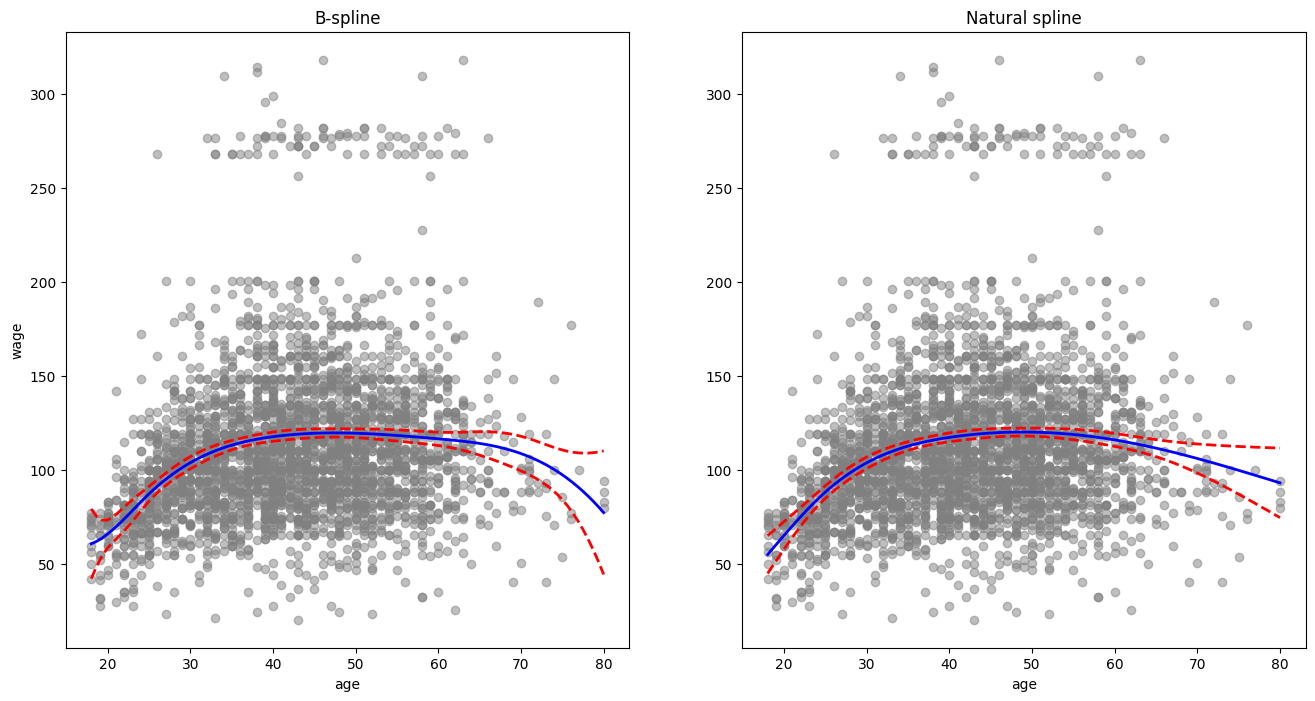

In [51]:
# Set up the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# First subplot: B-spline
axs[0].scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
for val, ls in zip([preds_bs.predicted_mean, bands_bs[:, 0], bands_bs[:, 1]], ['b', 'r--', 'r--']):
    axs[0].plot(age_grid, val, ls, linewidth=2)
axs[0].set_xlabel('age'); axs[0].set_ylabel('wage'); axs[0].set_title('B-spline')
# Second subplot: Natural spline
axs[1].scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
for val, ls in zip([preds_ns.predicted_mean, bands_ns[:, 0], bands_ns[:, 1]], ['b', 'r--', 'r--']):
    axs[1].plot(age_grid, val, ls, linewidth=2)
axs[1].set_xlabel('age'); axs[1].set_title('Natural spline');

# Smoothing Splines
- A smoothing spline is a specific type of Generalized Additive Model (GAM) with squared-error loss for one feature.
- We use package `pygam` to fit a smoothing spline.
- In package `pygam`, each column in a model matrix corresponds to a smoothing operation: 
    - 's' for smoothing spline
    - 'l' for linear
    - 'f' for categorical variables
- `lam` is the penalty parameter $\lambda$.

In [52]:
# Create a column ndarray for age
X_age = np.asarray(WageDF.age).reshape((-1,1))
X_age[:3]

array([[18],
       [24],
       [45]], dtype=int64)

In [53]:
# Fit a GAM with a linear term for age
gam = LinearGAM(s_gam(0, lam=0.6))
# s_gam(0, lam=0.6): it takes the first column (index=0)
# s_gam() take only one integer, not list. If multiple columns are needed, use sperate s_gam() for each column.
gam.fit(X_age, WageDF.wage)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

- We plot the smoothing spline with 5 lambdas: from $10^{-2}$ to $10^6$.

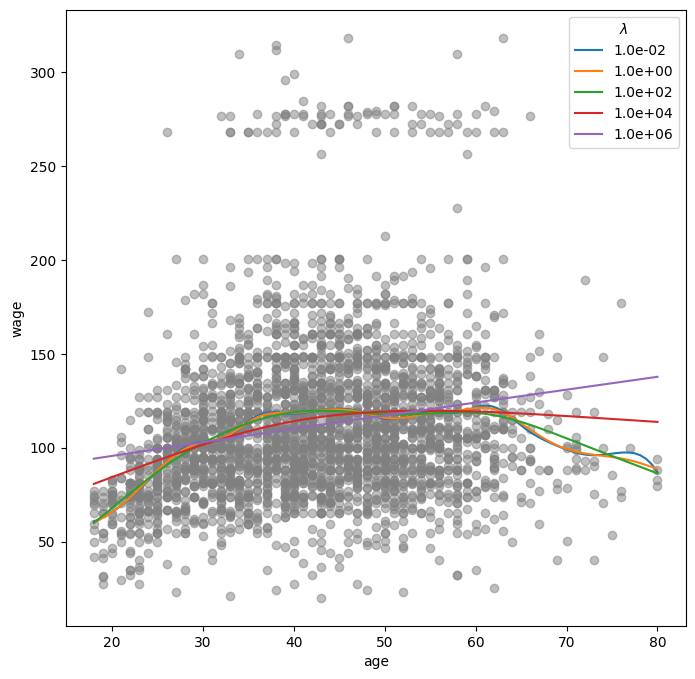

In [54]:
age_grid = np.linspace(WageDF.age.min(), WageDF.age.max(), 100) # to remind
# Create a grid of lambdas
lambdas = np.logspace(-2, 6, 5) # 0.01, 1, 100, 10000, 10^6
# Set a plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
# Plot the GAM fit for each lambda
for lam in lambdas:
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, WageDF.wage)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam))
ax.set_xlabel('age'); ax.set_ylabel('wage'); ax.legend(title=r'$\lambda$');

- The `pygam` package can perform a search for an optimal smoothing parameter.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


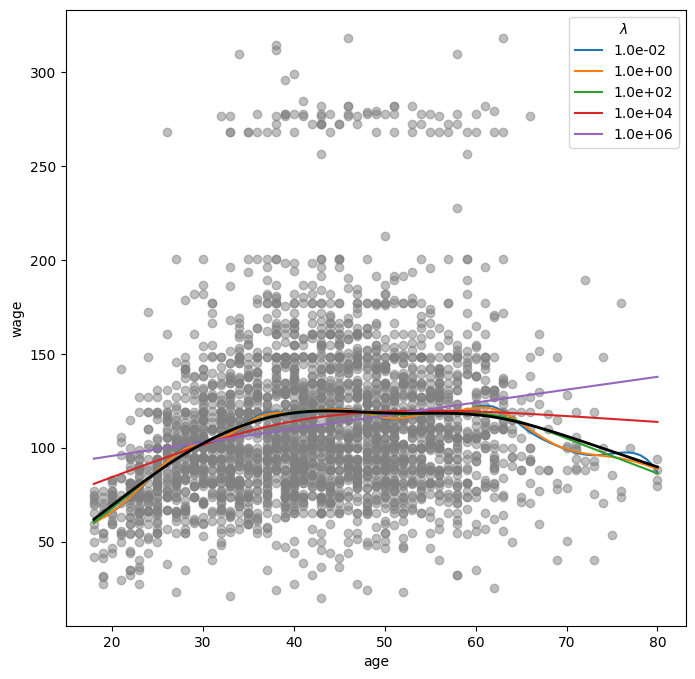

In [55]:
# Search the best lambda and fit the model
gam_opt = gam.gridsearch(X_age, WageDF.wage)
# Plot the model with the best lambda
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=2, color='k')
fig

In [56]:
# Show the chosen lambda
print('Best lambda:', gam_opt.lam)
# Show the degrees of freedom
print('Effective degrees of freedom:', gam_opt.statistics_['edof'].round(3))

Best lambda: [[251.18864315095772]]
Effective degrees of freedom: 5.644


- We use the package `ISLP.pygam` to fix the degree of freedom for the smoothing spline.
- First, we identify the lambda providing 4 degrees of freedom.

In [57]:
# To remind
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, WageDF.wage)
# Get the smooth term
smooth_term = gam.terms[0]
# Identify the lambda providing 4 effective degrees of freedom
lam4 = approx_lam(X_age, smooth_term, 4)
print('Lambda for 4 effective degrees of freedom:', lam4)
# Set this lambda for the smooth term
smooth_term.lam = lam4
# Show the effective degrees of freedom for this lambda
print('Effective degrees of freedom:', degrees_of_freedom(X_age, smooth_term))

Lambda for 4 effective degrees of freedom: [1446.68511262]
Effective degrees of freedom: 4.000000100003132


- We plot the smoothing spline with different degrees of freedom.
- Smoothing splines always have an intercept, so we adjust the desired degrees of freedom by adding 1
    - For example, `df=2` produces a straight line.

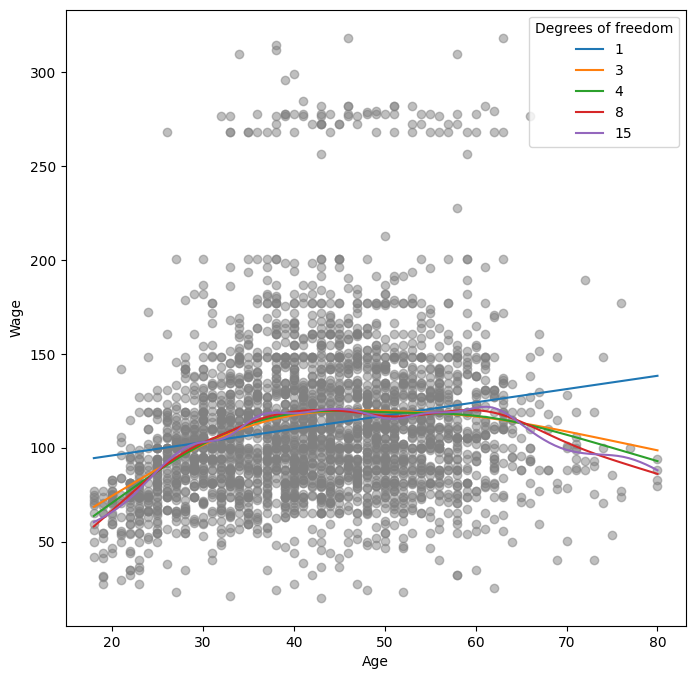

In [58]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age, WageDF.wage, facecolor='gray', alpha=0.5)
# Plot 5 degrees of freedom
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, gam.terms[0], df+1)
    gam.terms[0].lam = lam
    gam.fit(X_age, WageDF.wage)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df))
ax.set_xlabel('Age'); ax.set_ylabel('Wage');
ax.legend(title='Degrees of freedom');

# GAMs with Several Terms
- We fit GAM to predict `wage` using natural spline functions of `year` and `age`, and treating `education` as a qualitative predictor.
    - We use all columns of education, so we have to drop the intercept.

In [59]:
# Creat a matrix of basis functions for age and year
ns_age = NaturalSpline(df=4).fit_transform(WageDF.age)
ns_year = NaturalSpline(df=5).fit_transform(WageDF.year)
# Create a combined design matrix
Xs = [ns_age, ns_year, pd.get_dummies(WageDF.education)]
X_bh = np.hstack(Xs)
# Fit the model
gam_bh = sm.OLS(WageDF.wage, X_bh).fit()
summarize(gam_bh)

,coef,std err,t,P>|t|
x1,46.4460,3.732,12.446,0.000
x2,28.9349,3.884,7.449,0.000
x3,63.6722,9.231,6.898,0.000
x4,10.9669,7.650,1.434,0.152
x5,1.8374,3.177,0.578,0.563
x6,10.4409,3.790,2.755,0.006
x7,2.0020,3.399,0.589,0.556
x8,9.6055,4.053,2.370,0.018
x9,5.8989,2.419,2.438,0.015
x10,43.8013,4.383,9.993,0.000


- We construct partial dependence plots for each of the terms in the model.
1. Age

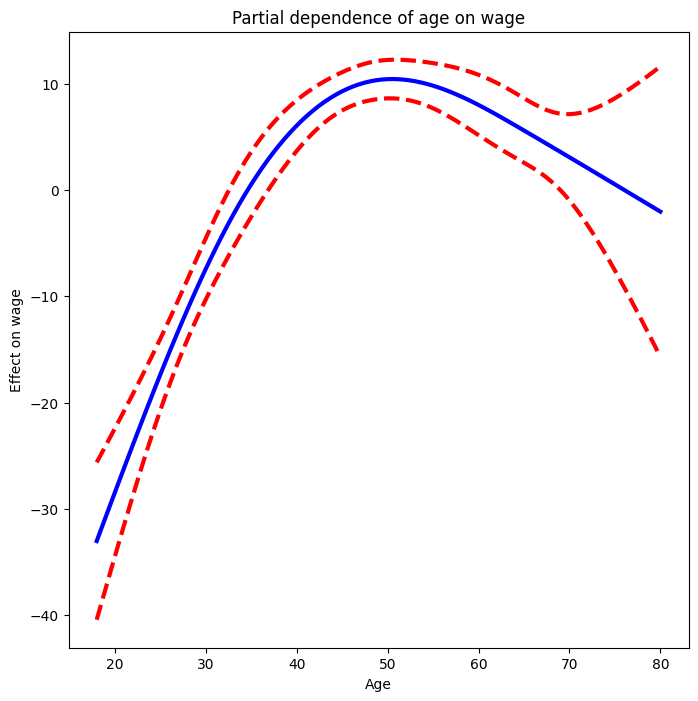

In [60]:
age_grid = np.linspace(WageDF.age.min(), WageDF.age.max(), 100) # to remind
# Copy the first 100 rows of the design matrix because age_grid has only 100 values
X_age_bh = X_bh.copy()[:100]
# Replace all values with the mean of its column
X_age_bh[:] = X_bh[:].mean(0)[None,:]
# Replace values of the first four columns with the basis functions for age
X_age_bh[:,:4] = NaturalSpline(df=4).fit_transform(age_grid)
# Calculate the predicted values
preds = gam_bh.get_prediction(X_age_bh)
# Calculate the confidence bands
bounds_age = preds.conf_int(alpha=0.05)
# Because we do not have the intercept, we need to subtract the center
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Draw the plot
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage');

- What we did above is create a new prediction matrix. All columns, except those for `age`, are constant and set to their training-data means. The four `age` columns are filled with the natural spline basis evaluated at the 100 `age_grid` values.
    * We created an `age` grid with 100 points and made a matrix `X_age_bh` with 100 rows and the same quantity of columns as `X_bh`.
    * We filled each row of this matrix with the means of the original columns.
    * We replaced the first four columns, which represent `age`, with the natural spline basis evaluated at the `age_grid` values.
2. year

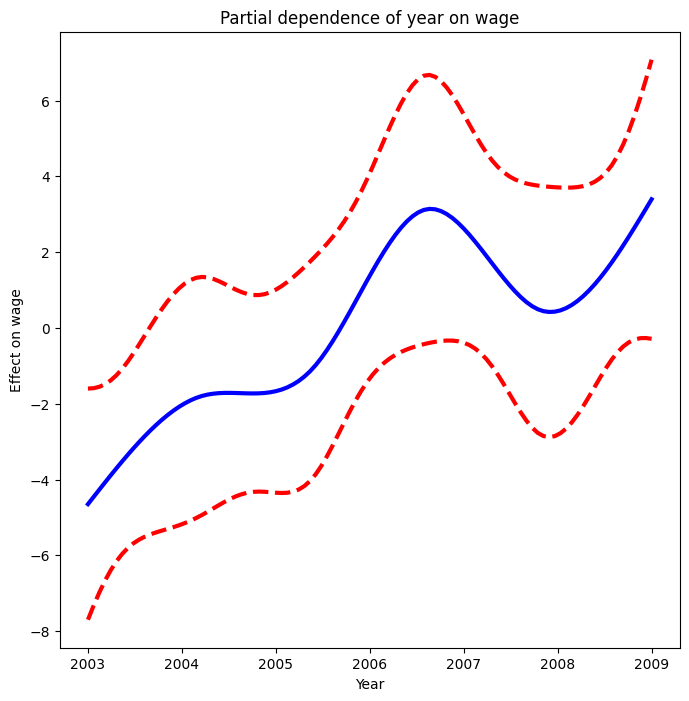

In [61]:
# Create a grid of years
year_grid = np.linspace(2003, WageDF.year.max(), 100)
# Copy the first 100 rows of the design matrix because year_grid has only 100 values
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
# Replace the values of the columns 4 to 9 with the basis functions for year
X_year_bh[:,4:9] = NaturalSpline(df=5).fit_transform(year_grid)
# Calculate the predicted values and confidence bands
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Draw the plot
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage');

- Now we fit the model using smoothing splines instead of natural splines. 
- All terms in the model are fit simultaneously, accounting for each other to explain the response.
- The `pygam` package requires matrices, so we convert the categorical series `education` to its array representation using the `cat.codes` attribute. 
- We use only seven basis functions for `year`, because it has 7 unique values (2003-2009).

In [62]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))

- `s_gam()` uses the default value of `lam=0.6` (arbitrary choice).
- `f_gam(2, lam=0)` uses `lam=0` to avoid any shrinkage.

In [63]:
# Convert the design matrix
Xgam = np.column_stack( [WageDF.age, WageDF.year, WageDF.education.cat.codes] )
Xgam[:3]

array([[  18, 2006,    0],
       [  24, 2004,    3],
       [  45, 2003,    2]], dtype=int64)

In [64]:
# Fit the model
gam_full = gam_full.fit(Xgam, WageDF.wage)

- `plot_pygam` from `ISLP.pygam` can use result from `LinearGAM()` to plot for each term.
1. Age

- The two `s_gam()` terms lead to smoothing spline fits, using a default (yet somewhat arbitrary) value for $\lambda$ (`lam=0.6`). For the categorical term `education`, mentioned using a `f_gam()` term, we set `lam=0` to avoid any shrinkage. We generate a partial dependence plot for `age` to observe the effects of these choices.
- The plot values are produced by the `pygam` package. The `ISLP.pygam` function `plot_gam()` simplifies generating partial-dependence plots compared to our previous example with natural splines.

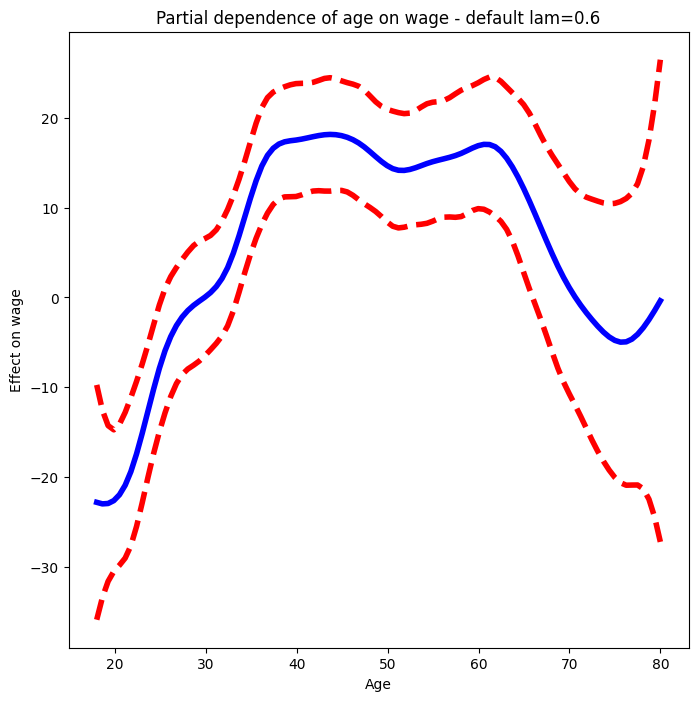

In [65]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Plot the first term
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6');

- The function appears fluctuating. 
- It's more intuitive to specify the `df` rather than a `lam` value.
- We refit a GAM using four degrees of freedom each for `age` and `year`. 
- We add one below considering the intercept of the smoothing spline.

In [66]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
# Refit the model
gam_full = gam_full.fit(Xgam, WageDF.wage)

- Remember that updating `age_term.lam` also updates it in `gam_full.terms[0]`, and the same applies for `year_term.lam`.
- Replotting for `age` reveals a smoother curve.

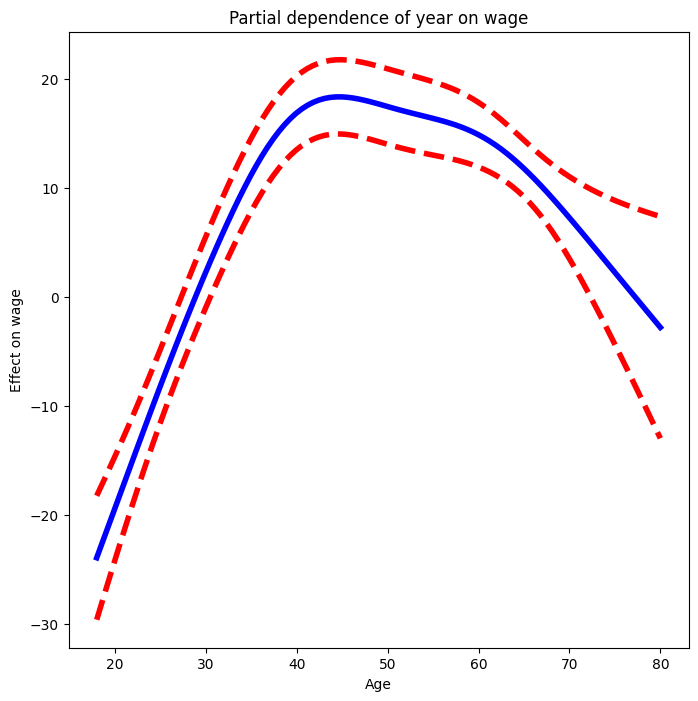

In [67]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage');

2. Year

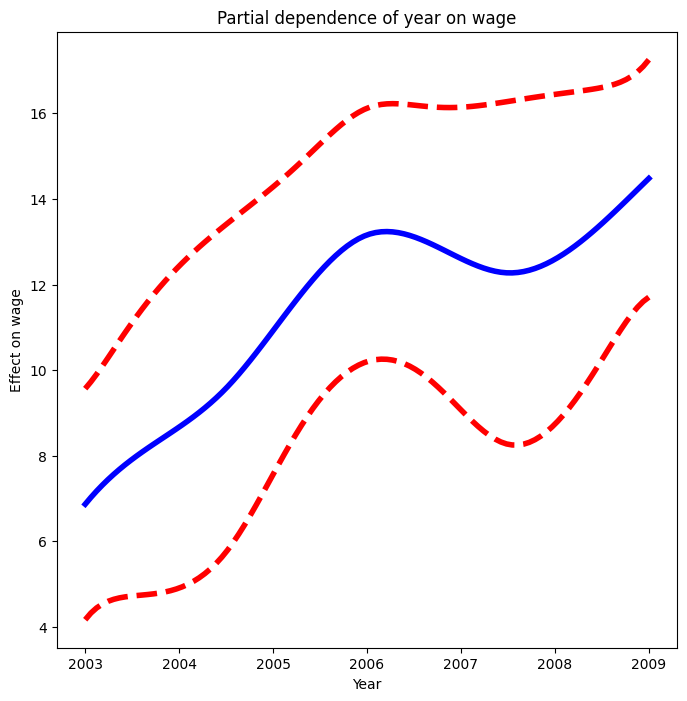

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plot_gam(gam_full, 1)
ax.set_xlabel('Year'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage');

3. Education
- `education` is a categorical variable.
- The partial dependence plot is different and more suitable for the set of fitted constants for each level of this variable.

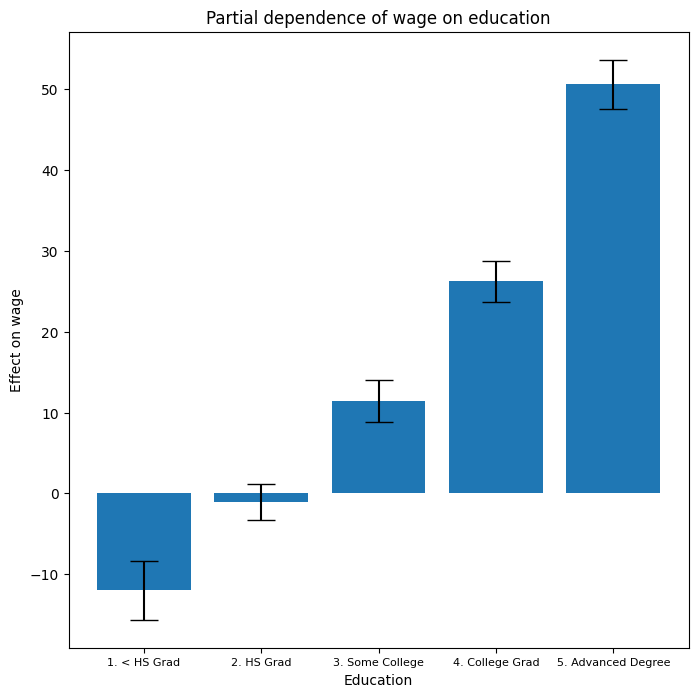

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education')
ax.set_xticklabels(WageDF['education'].cat.categories, fontsize=8);

## ANOVA Tests for Additive Models
- In all our models, the function of `year` seems linear.
- We can conduct a series of ANOVA tests to determine which model is best:
    - a GAM excludes `year`
    - a GAM includes `year` as a linear term
    - a GAM includes `year` as a smoothing spline

In [70]:
# GAM excludes year
gam_0 = LinearGAM(s_gam(0) + f_gam(2, lam=0))
gam_0.fit(Xgam, WageDF.wage)
# Set df = 4+1 for the age term
gam_0.terms[0].lam = approx_lam(Xgam, gam_0.terms[0], df=4+1)
# Refit the model
gam_0.fit(Xgam, WageDF.wage);

In [71]:
# GAM includes year as a linear term
gam_1 = LinearGAM(s_gam(0) + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_1.fit(Xgam, WageDF.wage)
# Set df = 4+1 for the age term
gam_1.terms[0].lam = approx_lam(Xgam, gam_1.terms[0], df=4+1)
# Refit the model
gam_1.fit(Xgam, WageDF.wage);

In [72]:
# GAM includes year as a smoothing spline
gam_2 = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + s_gam(2, lam=0))
gam_2.fit(Xgam, WageDF.wage)
# Set df = 4+1 for the age term
gam_2.terms[0].lam = approx_lam(Xgam, gam_2.terms[0], df=4+1)
# Set df = 4+1 for the year term
gam_2.terms[1].lam = approx_lam(Xgam, gam_2.terms[1], df=4+1)
# Refit the model
gam_2.fit(Xgam, WageDF.wage);


- We perform an ANOVA on the three models fitted above.

In [73]:
anova_gam(gam_0, gam_1, gam_2)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


- The result shows that the model with a linear term in `year` is the preffered model.
- We repeat the process for `age`.

In [74]:
# GAM excludes age
gam_0 = LinearGAM(s_gam(1) + f_gam(2, lam=0))
gam_0.fit(Xgam, WageDF.wage)
# Set df = 4+1 for the year term
gam_0.terms[0].lam = approx_lam(Xgam, gam_0.terms[0], df=4+1)
# Refit the model
gam_0.fit(Xgam, WageDF.wage);

In [75]:
# GAM includes age as a linear term
gam_1 = LinearGAM(l_gam(0, lam=0) + s_gam(1) + f_gam(2, lam=0))
gam_1.fit(Xgam, WageDF.wage)
# Set df = 4+1 for the year term
gam_1.terms[1].lam = approx_lam(Xgam, gam_1.terms[1], df=4+1)
# Refit the model
gam_1.fit(Xgam, WageDF.wage);

In [76]:
anova_gam(gam_0, gam_1, gam_2)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.972516e+06,2989.731372,NaN,NaN,NaN,NaN
1,3.847544e+06,2988.731515,124971.879105,0.999858,101.091386,1.698625e-07
2,3.693143e+06,2987.007254,154401.562381,1.724260,72.425087,1.525752e-07


- We repeat the process for `age` but based on linear term in `year`

In [77]:
# GAM excludes age and includes year as a linear term
gam_0 = LinearGAM(l_gam(1, lam=0) + f_gam(2, lam=0))
gam_0.fit(Xgam, WageDF.wage)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [78]:
# GAM includes age and year as a linear term
gam_1 = LinearGAM(l_gam(0, lam=0) + s_gam(1) + f_gam(2, lam=0))
gam_1.fit(Xgam, WageDF.wage)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=l(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [79]:
anova_gam(gam_0, gam_1, gam_2)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.978914e+06,2994.000004,NaN,NaN,NaN,NaN
1,3.846994e+06,2988.004790,131920.390718,5.995214,17.797025,1.416733e-05
2,3.693143e+06,2987.007254,153850.973752,0.997536,124.741734,4.995965e-08


- Both results show that the model with a non-linear term in `age` is the preffered model.
- There is a (verbose) `summary()` method for the GAM fit.

In [80]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\tuand\AppData\Local\Temp\ipykernel_6576\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


- We can make predictions from `gam` objects, similarly to `lm` objects, using the `predict()` method for the `gam` class. 
- We make predictions on the training set (fitted values)

In [81]:
Yhat = gam_full.predict(Xgam)
print('First three fitted values:', Yhat[:3])
print('First three true values:', WageDF.wage[:3].values)

First three fitted values: [ 52.3662492   99.63834745 111.7723448 ]
First three true values: [ 75.04315402  70.47601965 130.98217738]


- We use `LogisticGAM()` from `pygam` to fit a logistic regression GAM.

In [82]:
# Create the response variable for high earners
high_earn = WageDF.wage > 250
# Set and fit logistic GAM
gam_logit = LogisticGAM(s_gam(0) + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)
# Set df = 4+1 for the age term
gam_logit.terms[0].lam = approx_lam(Xgam, gam_logit.terms[0], df=4+1)
# Fit the model
gam_logit.fit(Xgam, high_earn);

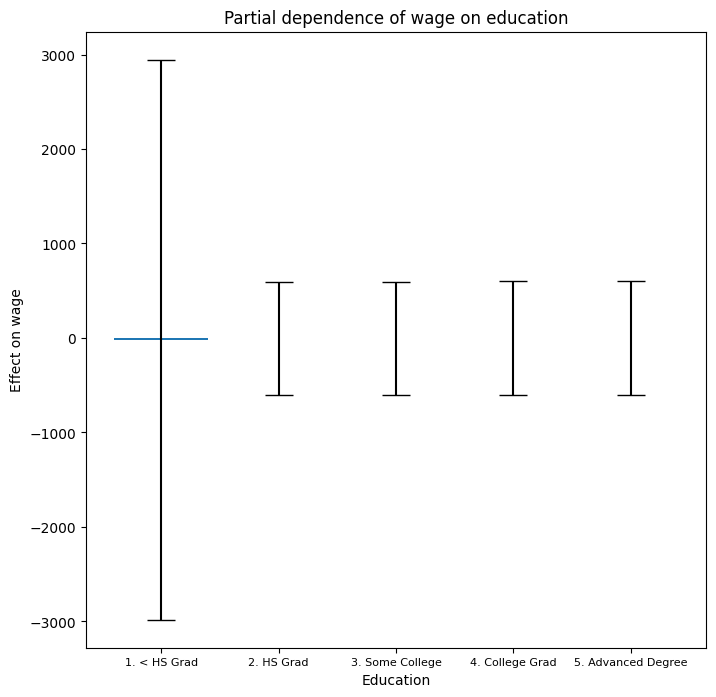

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education')
ax.set_xticklabels(WageDF['education'].cat.categories, fontsize=8);

- The model appears quite flat, with particularly high error bars for the first category. Let's examine the data more closely.

In [84]:
pd.crosstab(high_earn, WageDF['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
wage,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


- There aren't any high earners in the first education category, making it difficult for the model to fit.
- We fit a logistic regression GAM excluding all observations in this category, providing more reasonable results.

In [85]:
# Create a vector of categories for lower education
only_hs = WageDF.education == '1. < HS Grad'
# Remove rows with lower education
WageDF_hs = WageDF[~only_hs]
# Create the design matrix
# Subtract one from the codes of the category, due to a bug in pygam. 
# It just relabels the education values and hence has no effect on the fit.
Xgam_hs = np.column_stack([WageDF_hs.age, WageDF_hs.year, WageDF_hs.education.cat.codes-1])
# Create the response variable for high earners
high_earn_hs = WageDF_hs.wage > 250

In [86]:
# Set logistic GAM
gam_logit_hs = LogisticGAM(s_gam(0) + l_gam(1, lam=0) + f_gam(2, lam=0) )
gam_logit_hs.fit(Xgam_hs, high_earn_hs)
# Set df = 4+1 for the age term
gam_logit_hs.terms[0].lam = approx_lam(Xgam_hs, gam_logit_hs.terms[0], df=4+1)
# Fit the model
gam_logit_hs.fit(Xgam_hs, high_earn_hs)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

- Now that we've removed those observations, let's examine the effect of `education`, `year`, and `age` on the high earner status.

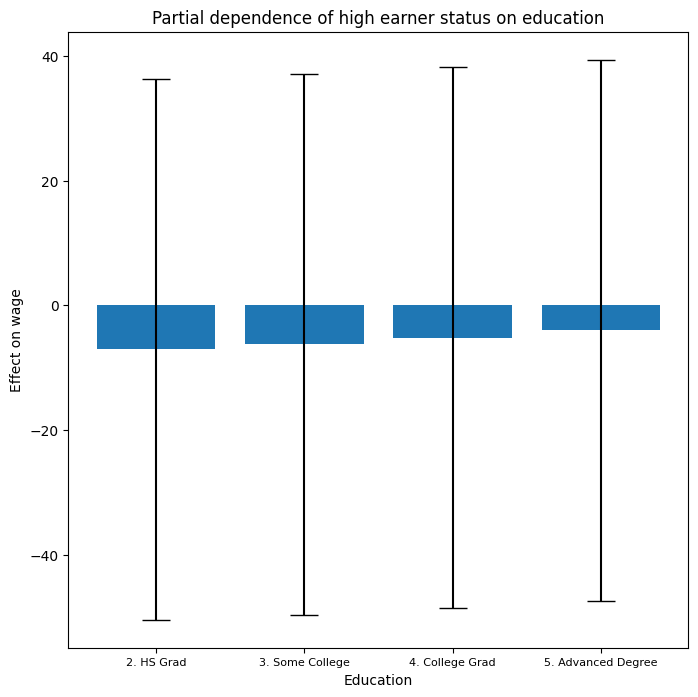

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_hs, 2)
ax.set_xlabel('Education'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education');
ax.set_xticklabels(WageDF_hs['education'].cat.categories[1:], fontsize=8);

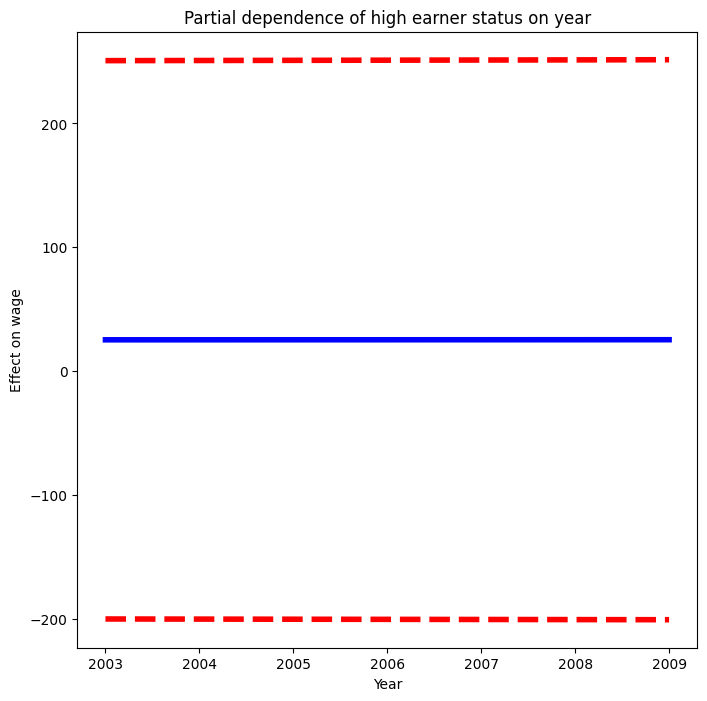

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_hs, 1)
ax.set_xlabel('Year'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year');

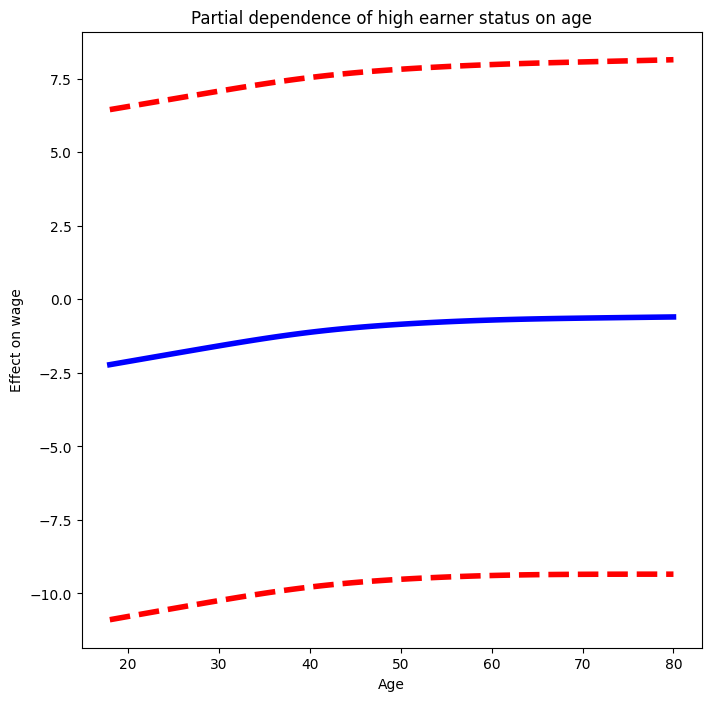

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_hs, 0)
ax.set_xlabel('Age'); ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age');

# Local Regression
- We use `lowess()` from `sm.nonparametric` to fit a local regression model.
- We fit local linear regression models using spans of 0.2 and 0.5, meaning each neighborhood consists of 20% or 50% of the observations.
- A span of 0.5 results in a smoother model than 0.2.

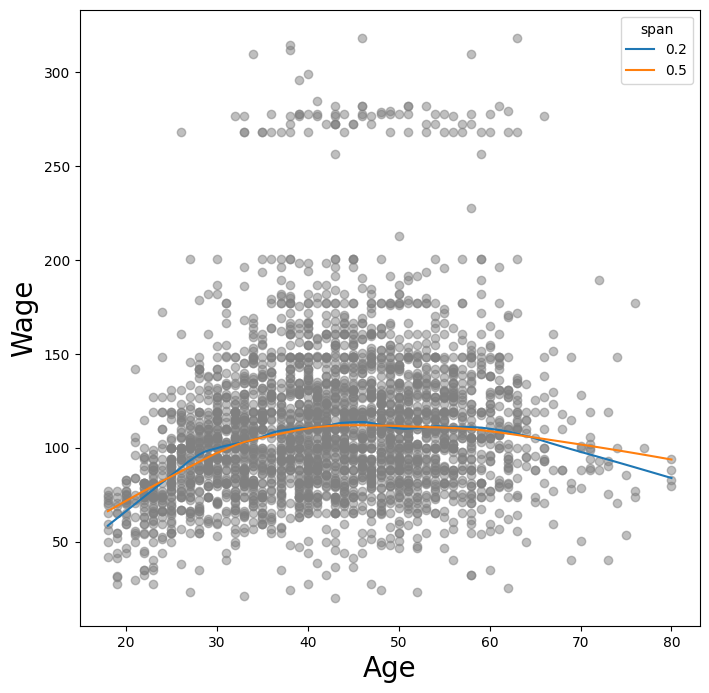

In [90]:
lowess = sm.nonparametric.lowess
# Set up the plot
fig, ax = plt.subplots(figsize=(8,8))
# Scatter plot of the data
ax.scatter(WageDF.age, WageDF.wage , facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(WageDF.wage, WageDF.age, frac=span, xvals=age_grid)
    ax.plot(age_grid, fitted,
            label='{:.1f}'.format(span))
ax.set_xlabel('Age', fontsize=20); ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='span');